## Prepare the dataset

In [ ]:
import glob
import pandas as pd
import os
import numpy as np
import openpyxl
import datetime
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import wofz, gamma
from sklearn.metrics import r2_score
from statistics import stdev

# Specify the directory path
dir_path = "/Users/yukiharuta/Desktop/Temp-Data/MAPbBr3-Paper/01_Image-processes"

# time 
x = 1.5

# Prepare an empty dataframe for summary
cols = ['ID', 
        'e(t)+SV (mm/h)',
        'L_0 (mm)',
        'L_x (mm)',
        'delta_L (mm)',
        'Inf_total_x (mL)',
        'de/dt',
        'est_mass',
        'RT (oC)',
        'RH (%)',
        'Evap (g/h)'
       ]

# Empty dataframe for data
data = pd.DataFrame(index=[], columns=cols)

# Get a list of full paths of folders in the directory
folder_paths = [os.path.join(dir_path, name) for name in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path, name))]
folder_paths.sort()
folder_paths = folder_paths[:-1] # remove "others" folder

# Remove the folder named ERROR (means there is no excel file)
for folder in folder_paths:
    if 'ERROR' in folder:
        folder_paths.remove(folder)

# Check how many folders were detected
print(f'{len(folder_paths)} folders were founded')

# Get data from each experiment
for i, source_dir in enumerate(folder_paths):
    folder_name = os.path.basename(source_dir)
    
    try:
        # Get excel poath
        excel_path = glob.glob(f'{source_dir}/*data.xlsx')[0]
        excel_path = excel_path.replace("~$","")
        
        # Read the first sheet
        df = pd.read_excel(excel_path)
        # Read the second and third sheet
        wb = openpyxl.load_workbook(excel_path)
        ws_P = wb["Parameters"]
        ws_I = wb["Information"]

        # Get Information (Parameters)
        ID = folder_name 
        RT = ws_I['C10'].value # Room temperature (ºC)
        RH = ws_I['C11'].value # Humidity (RH%)
        
        # find the index for t = XX h
        time = df['Time (h)'].to_list()
        time_x = [abs(n-x) for n in time]
        time_index = time_x.index(min(time_x))
        
        # Growth rate
        Rs = df['Smth_G (mm/h)'].to_list()
        R_x = Rs[time_index]
        
        ets = df['e(t)'].to_list()
        SV = float(ws_P['I6'].value) # Set growth rate (mm/h)
        R2s = [n + SV for n in ets]
        R_x2 = R2s[time_index]
        
        dedts = df['de(t)/dt'].to_list()
        dedt = dedts[time_index]
        
        est_mass_s = df['Est-Mass (g)'].to_list()
        est_mass = est_mass_s[time_index]
        
        # Length
        Ls = df['Smth_L (mm)'].to_list()
        L_0 = Ls[0]
        L_x = Ls[time_index]
        delta_L = L_x - L_0
        
        # Infusion
        Inf_0 = ws_P['I5'].value # Initial infusion rate (mL/h)
        totals = df['Total Inf'].to_list()
        Inf_total_x = totals[time_index]

        # Get Information (Results)
        Evap = ws_I['I6'].value # Average evaporation rate (g/h)
        
        wb.close()
        
        # Dataframe for the parameters
        record = [[ID, R_x2, L_0, L_x, delta_L, Inf_total_x, dedt, est_mass, RT, RH, Evap]]
        df_record = pd.DataFrame(data=record, columns=cols)
        # Add one row
        data = pd.concat([data, df_record], ignore_index=True, axis=0)
        
        print(f'{i+1}: COMPLETE {folder_name}')
                    
    except Exception as e:
        print(f'{i+1}: ERROR in {folder_name}')
        print(e)
        record = [[folder_name, float(folder_name[:6])]]
        for i in range(len(cols)-2):
            record[0].append(None)
        df_record = pd.DataFrame(data=record, columns=cols)
        data = pd.concat([data, df_record], ignore_index=True, axis=0)
        pass

print('COMPLETE')

# Save the data
with pd.ExcelWriter(f'PROJECT-ANALYSIS-{datetime.datetime.now().strftime("%y%m%d")}.xlsx') as writer:
    data.to_excel(writer, sheet_name='Data')

data

## Preparing the model by Random Forrest

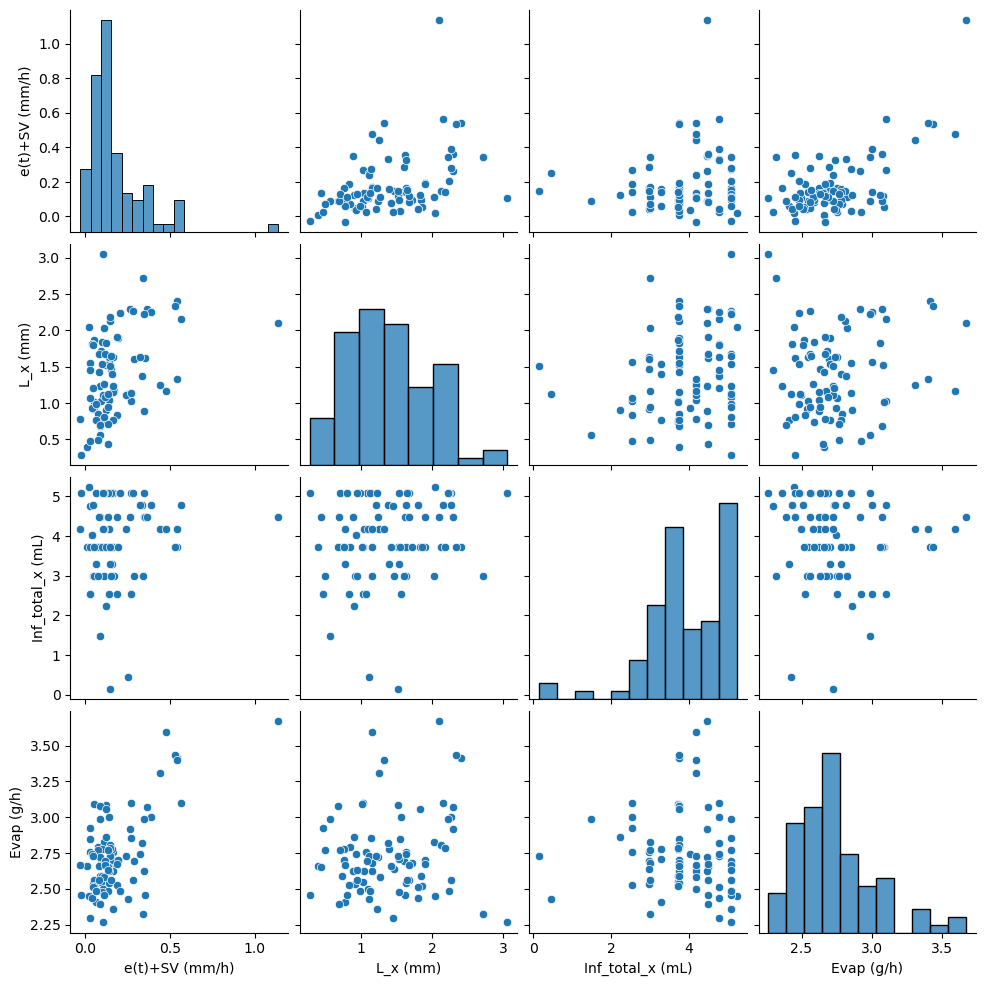

In [6]:
#filename = input('Enter filename\n')
# filename = "/Users/yukiharuta/Desktop/Temp-Data/MAPbBr3-Paper/10_Data-Summary/230703-ANALYSIS-First90min.xlsx"
filename = "/Users/yukiharuta/Desktop/Python/Evap-prediction/PROJECT-ANALYSIS-231023.xlsx"
ans="Evap (g/h)"

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

df = pd.read_excel(filename, sheet_name = 'model')

sns.pairplot(df)
plt.show()

N=900
RMSE train: 0.08, test: 0.30
R^2 train: 0.90, test: 0.57
9% probability of +-0.05 g/h error
11% probability of +-0.10 g/h error


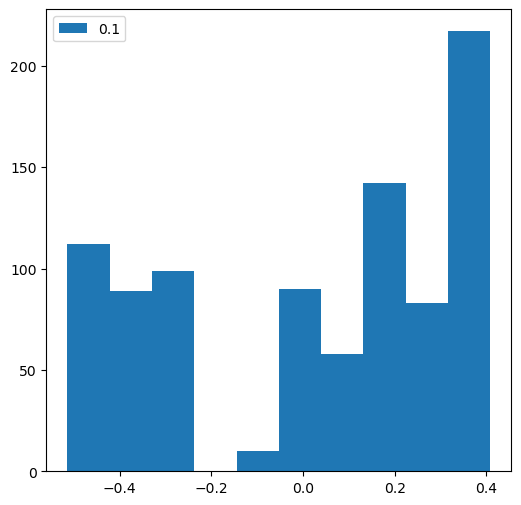

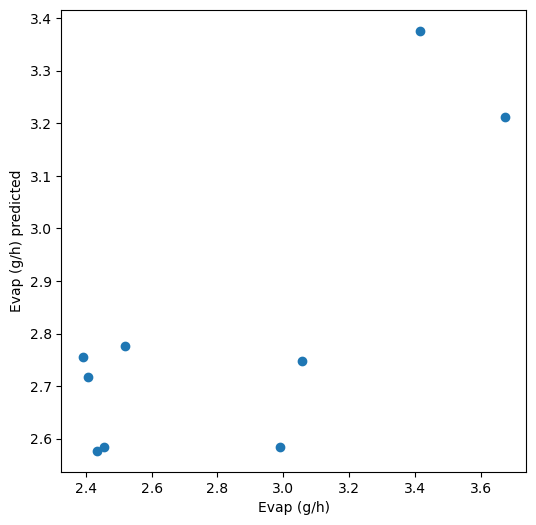

In [15]:
from sklearn.ensemble import RandomForestRegressor #ランダムフォレストを行うライブラリ
from sklearn.model_selection import train_test_split #データを分割するライブラリ
import numpy as np
from sklearn.metrics import r2_score            # 決定係数
from sklearn.metrics import mean_squared_error

col=df.columns.drop([ans])
# col=df.columns.drop('ID')
X, Y = df[col], df[ans]

test_sizes = [0.1]

for test_size in test_sizes:
    Errors = []
    for i in range(100):
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=1) #X,YをAIに学習させるデータと、テスト用のデータに分ける
        RF= RandomForestRegressor(n_estimators=200, max_depth=10)
        RF.fit(X_train, Y_train)

        Y_test_pred  = RF.predict(X_test)
        Y_train_pred = RF.predict(X_train)
        
        Error = [a-b for a,b in zip(Y_test_pred, Y_test)]
        for e in Error:
            Errors.append(e)
    
    print(f'N={len(Errors)}')
    # 平均平方二乗誤差(RMSE)
    print('RMSE train: %.2f, test: %.2f' % (
            mean_squared_error(Y_train, Y_train_pred, squared=False), # 学習
            mean_squared_error(Y_test, Y_test_pred, squared=False)    # テスト
          ))

    # 決定係数(R^2)
    print('R^2 train: %.2f, test: %.2f' % (
            r2_score(Y_train, Y_train_pred), # 学習
            r2_score(Y_test, Y_test_pred)    # テスト
          ))
    
    # +- 0.05 possibility
    success = [1 for n in Errors if -0.05<n<0.05]
    print(f'{int(len(success)/len(Errors)*100)}% probability of +-0.05 g/h error')
    success2 = [1 for n in Errors if -0.1<n<0.1]
    print(f'{int(len(success2)/len(Errors)*100)}% probability of +-0.10 g/h error')
    plt.figure(figsize=(6,6))
    plt.hist(Errors, label = str(test_size), density=False)
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(6,6))
    plt.scatter(Y_test,Y_test_pred)
    plt.xlabel(ans)
    plt.ylabel(ans+" predicted")
    plt.show()

    # plt.scatter(Y_test,Errors)
    # plt.xlabel(ans)
    # plt.ylabel('Error')
    # plt.show()

In [16]:
import glob
import pandas as pd
import os
import numpy as np
import openpyxl
import datetime
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import wofz, gamma
from sklearn.metrics import r2_score
from statistics import stdev

# Specify the directory path
dir_path = "/Users/yukiharuta/Desktop/Temp-Data/MAPbBr3-Paper/01_Image-processes"

# time 
x = 1.5

# Prepare an empty dataframe for summary
cols = ['ID', 
        'Pred (g/h)',
        'Evap (g/h)',
        'Error'
       ]

# Empty dataframe for data
data = pd.DataFrame(index=[], columns=cols)

# Get a list of full paths of folders in the directory
folder_paths = [os.path.join(dir_path, name) for name in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path, name))]
folder_paths.sort()
folder_paths = folder_paths[:-1] # remove "others" folder

# Remove the folder named ERROR (means there is no excel file)
for folder in folder_paths:
    if 'ERROR' in folder:
        folder_paths.remove(folder)

# Check how many folders were detected
print(f'{len(folder_paths)} folders were founded')

# Get data from each experiment
for i, source_dir in enumerate(folder_paths):
    folder_name = os.path.basename(source_dir)
    
    try:
        # Get excel poath
        excel_path = glob.glob(f'{source_dir}/*data.xlsx')[0]
        excel_path = excel_path.replace("~$","")
        
        # Read the second and third sheet
        wb = openpyxl.load_workbook(excel_path)
        ws_P = wb["Parameters"]
        ws_I = wb["Information"]

        # Get Information (Parameters)
        ID = folder_name 
        
        # Get Information (Results)
        Evap = ws_I['I6'].value # Average evaporation rate (g/h)
        P_Evap = ws_I['C13'].value # Predicted evaporation rate (g/h)
        Error = P_Evap - Evap
        
        wb.close()
        
        # Dataframe for the parameters
        record = [[ID, Evap, P_Evap, Error]]
        df_record = pd.DataFrame(data=record, columns=cols)
        # Add one row
        data = pd.concat([data, df_record], ignore_index=True, axis=0)
        
        print(f'{i+1}: COMPLETE {folder_name}')
                    
    except Exception as e:
        print(f'{i+1}: ERROR in {folder_name}')
        print(e)
        record = [[folder_name, float(folder_name[:6])]]
        for i in range(len(cols)-2):
            record[0].append(None)
        df_record = pd.DataFrame(data=record, columns=cols)
        data = pd.concat([data, df_record], ignore_index=True, axis=0)
        pass

print('COMPLETE')

# Save the data
with pd.ExcelWriter(f'Evap-Pred-Result-{datetime.datetime.now().strftime("%y%m%d")}.xlsx') as writer:
    data.to_excel(writer, sheet_name='Data')

data

97 folders were founded
1: ERROR in 230118_A_Bulk-P3D2
unsupported operand type(s) for -: 'NoneType' and 'float'
2: ERROR in 230119_A_Bulk-P3D2-10h-double
unsupported operand type(s) for -: 'NoneType' and 'float'
3: ERROR in 230121_A_BulkPD5.1
unsupported operand type(s) for -: 'NoneType' and 'float'
4: ERROR in 230122_A_BulkPD5.1-FALSE
unsupported operand type(s) for -: 'NoneType' and 'float'
5: ERROR in 230124_A_Gset0.2-Bulk
unsupported operand type(s) for -: 'NoneType' and 'float'
6: ERROR in 230128_A_0.1mmh-48hrs
unsupported operand type(s) for -: 'NoneType' and 'float'
7: ERROR in 230130_A_0.8mmh-about6hrs
unsupported operand type(s) for -: 'NoneType' and 'float'
8: ERROR in 230131_A_0.3growth
unsupported operand type(s) for -: 'NoneType' and 'float'
9: ERROR in 230202_A_bulk0.4
unsupported operand type(s) for -: 'NoneType' and 'float'
10: ERROR in 230204_A_0.5
unsupported operand type(s) for -: 'NoneType' and 'float'
11: ERROR in 230205_A_0.6
unsupported operand type(s) for -: 'N

,ID,Pred (g/h),Evap (g/h),Error
0,230118_A_Bulk-P3D2,230118.000000,NaN,NaN
1,230119_A_Bulk-P3D2-10h-double,230119.000000,NaN,NaN
2,230121_A_BulkPD5.1,230121.000000,NaN,NaN
3,230122_A_BulkPD5.1-FALSE,230122.000000,NaN,NaN
4,230124_A_Gset0.2-Bulk,230124.000000,NaN,NaN
...,...,...,...,...
92,231018_AY1_0.2mmh,2.558989,3.013718,0.454729
93,231018_AY2_0.2mmh,2.264059,2.897889,0.63383
94,231018_AY3_0.2mmh-FALSE,2.481835,2.780165,0.298329
95,231018_AY4_0.2mmh,2.988646,2.880209,-0.108437
